In [1]:
import sys
import os
#sys.path.append(os.path.abspath(".."))
os.chdir("D:/ML_SP_projects/voice-from-noise")

In [2]:
from pathlib import Path

# Check if the file really exists
Path("data\TIMIT\TRAIN\DR1\MWAR0\SA1.WAV").exists()


True

In [3]:
from src.preprocess import preprocess_timit

preprocess_timit()

Skipping non-wav file: SA1.PHN
Skipping non-wav file: SA1.TXT
Processing TIMIT file: SA1.WAV
Processing: data/TIMIT/TRAIN/DR2/FAEM0\SA1.WAV
Loaded file: data/TIMIT/TRAIN/DR2/FAEM0\SA1.WAV, length: 53863
Skipping non-wav file: SA1.WRD
Skipping non-wav file: SA2.PHN
Skipping non-wav file: SA2.TXT
Processing TIMIT file: SA2.WAV
Processing: data/TIMIT/TRAIN/DR2/FAEM0\SA2.WAV
Loaded file: data/TIMIT/TRAIN/DR2/FAEM0\SA2.WAV, length: 45261
Skipping non-wav file: SA2.WRD
Skipping non-wav file: SI1392.PHN
Skipping non-wav file: SI1392.TXT
Processing TIMIT file: SI1392.WAV
Processing: data/TIMIT/TRAIN/DR2/FAEM0\SI1392.WAV
Loaded file: data/TIMIT/TRAIN/DR2/FAEM0\SI1392.WAV, length: 76186
Skipping non-wav file: SI1392.WRD
Skipping non-wav file: SI2022.PHN
Skipping non-wav file: SI2022.TXT
Processing TIMIT file: SI2022.WAV
Processing: data/TIMIT/TRAIN/DR2/FAEM0\SI2022.WAV
Loaded file: data/TIMIT/TRAIN/DR2/FAEM0\SI2022.WAV, length: 36045
Skipping non-wav file: SI2022.WRD
Skipping non-wav file: SI762

In [2]:
from src.preprocess import preprocess_esc50, balance_dataset

balance_dataset()


Balancing to 2598 samples total for human and non-human combined...
Balancing each non-human class to 236 samples...


In [2]:
%run src/train.py

Training binary (human vs. non-human) classifier with balanced sample split...
Saved binary classifier to svm_human_vs_nonhuman.joblib

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       519
           1       1.00      0.99      0.99       520

    accuracy                           0.99      1039
   macro avg       0.99      0.99      0.99      1039
weighted avg       0.99      0.99      0.99      1039


Training multi-class (non-human categories) classifier...
Saved multi-class classifier and class mapping.

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.51      0.64        47
           1       0.83      0.79      0.81        48
           2       0.94      0.66      0.78        47
           3       0.69      0.69      0.69        48
           4       0.69      0.79      0.73        47
           5       0.57      0.91      0.70        47
  

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()
    
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))


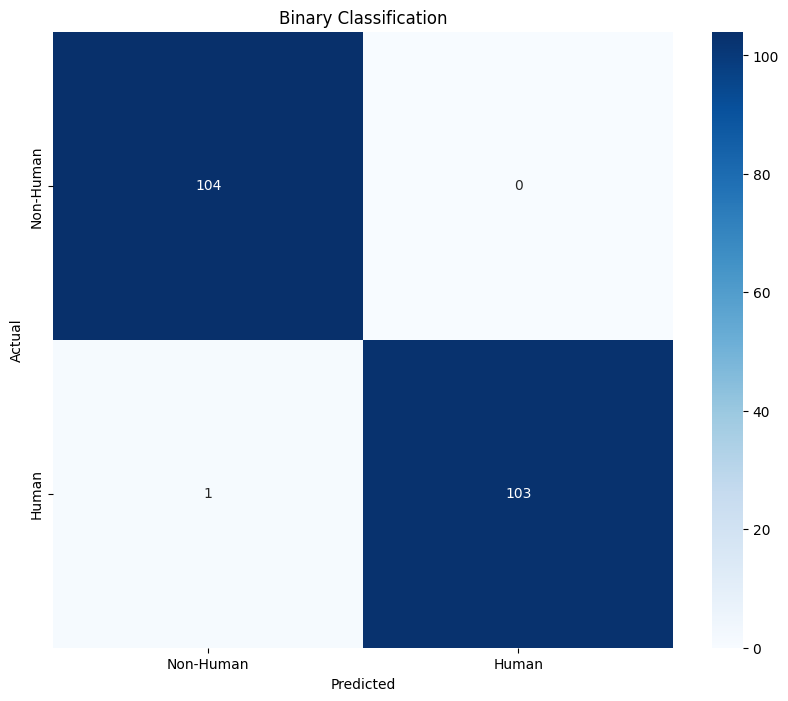


Classification Report:

              precision    recall  f1-score   support

   Non-Human       0.99      1.00      1.00       104
       Human       1.00      0.99      1.00       104

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208



In [6]:
from src.train import load_binary_dataset_balanced_split
from sklearn.model_selection import train_test_split
import joblib

_,X,_, y = load_binary_dataset_balanced_split()  # returns full data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

binary_model = joblib.load("models/svm_human_vs_nonhuman.joblib")
y_pred = binary_model.predict(X_test)

plot_confusion_matrix(y_test, y_pred, class_names=["Non-Human", "Human"], title="Binary Classification")


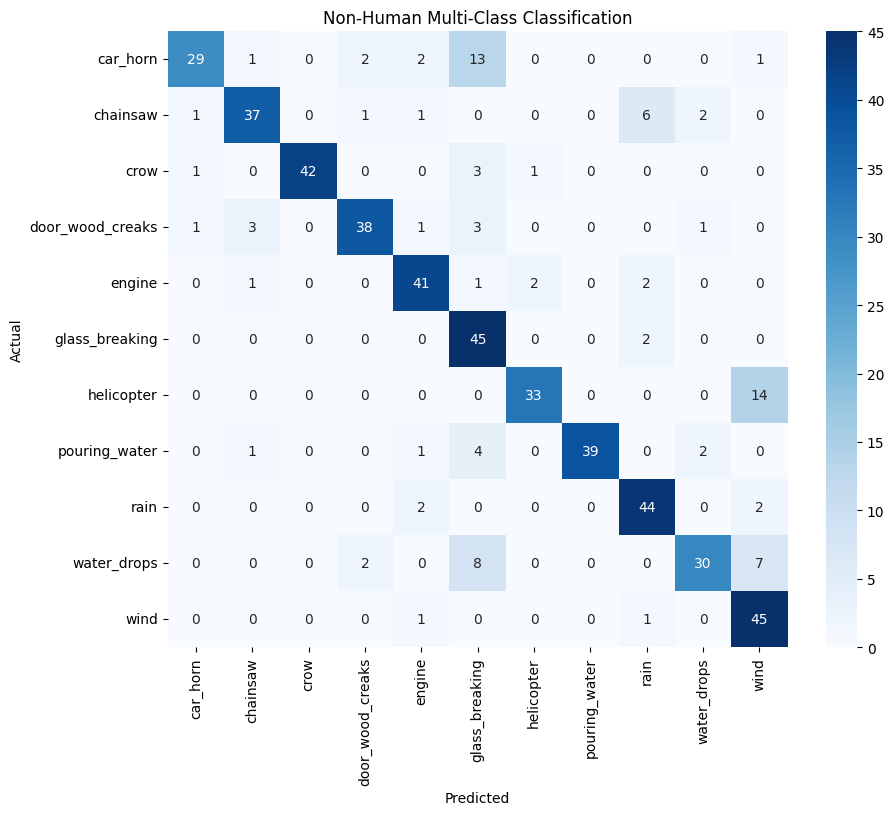


Classification Report:

                  precision    recall  f1-score   support

        car_horn       0.91      0.60      0.72        48
        chainsaw       0.86      0.77      0.81        48
            crow       1.00      0.89      0.94        47
door_wood_creaks       0.88      0.81      0.84        47
          engine       0.84      0.87      0.85        47
  glass_breaking       0.58      0.96      0.73        47
      helicopter       0.92      0.70      0.80        47
   pouring_water       1.00      0.83      0.91        47
            rain       0.80      0.92      0.85        48
     water_drops       0.86      0.64      0.73        47
            wind       0.65      0.96      0.78        47

        accuracy                           0.81       520
       macro avg       0.85      0.81      0.82       520
    weighted avg       0.85      0.81      0.82       520



In [5]:
from src.train import load_nonhuman_multiclass_dataset
from sklearn.model_selection import train_test_split

# Load data & model
X, y, class_to_idx = load_nonhuman_multiclass_dataset()
idx_to_class = {v: k for k, v in class_to_idx.items()}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

multi_model = joblib.load("models/svm_nonhuman_classifier.joblib")
y_pred = multi_model.predict(X_test)

# Plot
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
plot_confusion_matrix(y_test, y_pred, class_names=class_names, title="Non-Human Multi-Class Classification")


In [7]:
import hashlib

def hash_vec(vec):
    return hashlib.sha1(vec.tobytes()).hexdigest()

train_hashes = set([hash_vec(x) for x in X_train])
test_hashes = set([hash_vec(x) for x in X_test])
overlap = train_hashes.intersection(test_hashes)

print(f"Number of overlapping feature vectors: {len(overlap)}")


Number of overlapping feature vectors: 10
